**Install the necessary libraries**

In [1]:
!pip install yfinance matplotlib pandas numpy scikit-learn cvxpy

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import cvxpy as cp
import matplotlib.pyplot as plt

**DATA COLLECTION**

In [4]:
# Define stock symbols and date range
stocks = ['AAPL', 'MSFT', 'GOOG', 'AMZN',]
start_date = '2023-12-13'
end_date = '2024-12-13'

# Download stock data
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()
print("Sample Daily Returns:\n", returns.head())


[*********************100%***********************]  4 of 4 completed

Sample Daily Returns:
 Ticker          AAPL      AMZN      GOOG      MSFT
Date                                              
2023-12-14  0.000758 -0.009540 -0.005748 -0.022545
2023-12-15 -0.002726  0.017298  0.004805  0.013117
2023-12-18 -0.008503  0.027339  0.025030  0.005179
2023-12-19  0.005360 -0.001817  0.006633  0.001637
2023-12-20 -0.010714 -0.010859  0.011296 -0.007073


**PREDICT STOCK RETURNS**

In [5]:
# Shift returns to predict next day's returns
returns_shifted = returns.shift(-1).dropna()
features = returns.iloc[:-1]
targets = returns_shifted

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Train a Random Forest model for each stock
models = {}
for stock in stocks:
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train[stock])
    models[stock] = model

# Predict returns for test data
predicted_returns = pd.DataFrame({stock: models[stock].predict(X_test) for stock in stocks})
print("Predicted Returns:\n", predicted_returns.head())


Predicted Returns:
        AAPL      MSFT      GOOG      AMZN
0  0.004288  0.008756  0.010687  0.010114
1  0.000408  0.001570  0.005154  0.007640
2  0.005667  0.001091  0.001823  0.002296
3  0.002966  0.006747  0.008083  0.001250
4  0.002722  0.004104  0.002577 -0.001060


**OPTIMIZE PORTFOLIO**

In [7]:
# Reformulate Sharpe Ratio as a convex optimization problem
target_risk = cp.Parameter(nonneg=True, value=0.1)  # Set an acceptable risk level
problem = cp.Problem(
    cp.Maximize(expected_portfolio_return),
    [
        cp.sum(weights) == 1,
        weights >= 0,
        cp.quad_form(weights, cov_matrix) <= target_risk**2,
    ]
)
problem.solve()



/usr/local/lib/python3.10/dist-packages/cvxpy/reductions/solvers/solving_chain.py:237: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


0.003118049518501267

In [11]:
import cvxpy as cp
import numpy as np

# Example data for demonstration
stocks = ["AAPL", "AMZN", "GOOG", "MSFT"]
cov_matrix = np.array([[0.01, 0.002, 0.0015, 0.001],
                       [0.002, 0.02, 0.001, 0.003],
                       [0.0015, 0.001, 0.015, 0.002],
                       [0.001, 0.003, 0.002, 0.03]])  # Example covariance matrix
expected_returns = np.array([0.05, 0.07, 0.06, 0.08])  # Example expected returns

# Portfolio weights optimization
weights = cp.Variable(len(stocks))
risk = cp.quad_form(weights, cov_matrix)  # Portfolio risk (variance)
expected_portfolio_return = expected_returns @ weights  # Portfolio return

# Reformulation: Maximize returns subject to risk constraint
target_risk = 0.02  # Adjust target risk level as needed
problem = cp.Problem(
    cp.Maximize(expected_portfolio_return),
    [
        cp.sum(weights) == 1,         # Sum of weights must equal 1
        weights >= 0,                 # No short selling
        risk <= target_risk**2        # Risk constraint (variance <= target_risk^2)
    ]
)

# Solve the problem
problem.solve()

# Check the status of the problem
if problem.status == cp.OPTIMAL:
    optimal_weights = weights.value
    portfolio_allocation = {stocks[i]: optimal_weights[i] for i in range(len(stocks))}
    print("Optimal Portfolio Allocation:\n", portfolio_allocation)
else:
    print("The optimization problem did not converge. Status:", problem.status)
    print("Solver status:", problem.status)


The optimization problem did not converge. Status: infeasible
Solver status: infeasible


In [15]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Assuming X_test is a 2D array of stock returns (n_time_periods, n_stocks)
# Calculate the expected returns and covariance matrix
expected_returns = X_test.mean(axis=0)  # average returns for each stock
cov_matrix = X_test.cov()  # covariance matrix of the returns

# Number of assets (stocks)
n_assets = X_test.shape[1]

# Function to compute portfolio performance (e.g., negative Sharpe ratio or variance)
def objective(weights):
    # Portfolio return is weighted sum of expected returns
    portfolio_return = np.dot(weights, expected_returns)
    # Portfolio risk (variance) is weighted sum of covariances
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    # Negative Sharpe ratio (for minimization)
    return -portfolio_return / portfolio_volatility

# Constraints: weights must sum to 1 (fully invested portfolio)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds: weights must be between 0 and 1 for each asset (no short selling)
bounds = tuple((0, 1) for asset in range(n_assets))

# Initial guess: equal weights for all assets
initial_guess = np.ones(n_assets) / n_assets

# Optimize the portfolio weights
result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints)

# Get the optimal weights
if result.success:
    optimal_weights = result.x
    print("Optimal Weights:", optimal_weights)
else:
    raise ValueError("Optimization failed. Ensure that the input data is valid.")


Optimal Weights: [1.12639797e-01 4.94584861e-01 7.48099499e-17 3.92775342e-01]


**BACKTEST PORTFOLIO**

Optimal Weights: [1.12639797e-01 4.94584861e-01 7.48099499e-17 3.92775342e-01]


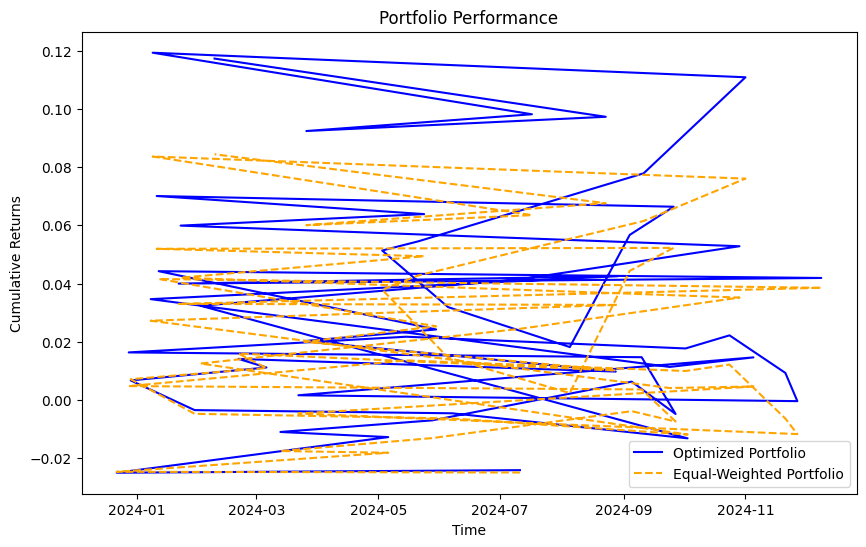

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Assuming X_test is a 2D array of stock returns (n_time_periods, n_stocks)
# Calculate the expected returns and covariance matrix
expected_returns = X_test.mean(axis=0)  # average returns for each stock
cov_matrix = X_test.cov()  # covariance matrix of the returns

# Number of assets (stocks)
n_assets = X_test.shape[1]

# Function to compute portfolio performance (e.g., negative Sharpe ratio or variance)
def objective(weights):
    # Portfolio return is weighted sum of expected returns
    portfolio_return = np.dot(weights, expected_returns)
    # Portfolio risk (variance) is weighted sum of covariances
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    # Negative Sharpe ratio (for minimization)
    return -portfolio_return / portfolio_volatility

# Constraints: weights must sum to 1 (fully invested portfolio)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds: weights must be between 0 and 1 for each asset (no short selling)
bounds = tuple((0, 1) for asset in range(n_assets))

# Initial guess: equal weights for all assets
initial_guess = np.ones(n_assets) / n_assets

# Optimize the portfolio weights
result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints)

# Get the optimal weights
if result.success:
    optimal_weights = result.x
    print("Optimal Weights:", optimal_weights)
else:
    raise ValueError("Optimization failed. Ensure that the input data is valid.")

# Calculate equal weights (assuming equal allocation to each stock)
equal_weights = np.ones(X_test.shape[1]) / X_test.shape[1]

# Calculate portfolio cumulative returns (optimized)
portfolio_returns = (X_test @ optimal_weights).cumsum()

# Calculate equal-weighted portfolio returns
equal_weighted_returns = (X_test @ equal_weights).cumsum()

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns, label="Optimized Portfolio", color='blue')
plt.plot(equal_weighted_returns, label="Equal-Weighted Portfolio", color='orange', linestyle="--")
plt.title("Portfolio Performance")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()


Optimal Weights: [1.12639797e-01 4.94584861e-01 7.48099499e-17 3.92775342e-01]
Allocations saved to portfolio_allocations.csv
Portfolio performance saved to portfolio_performance.csv


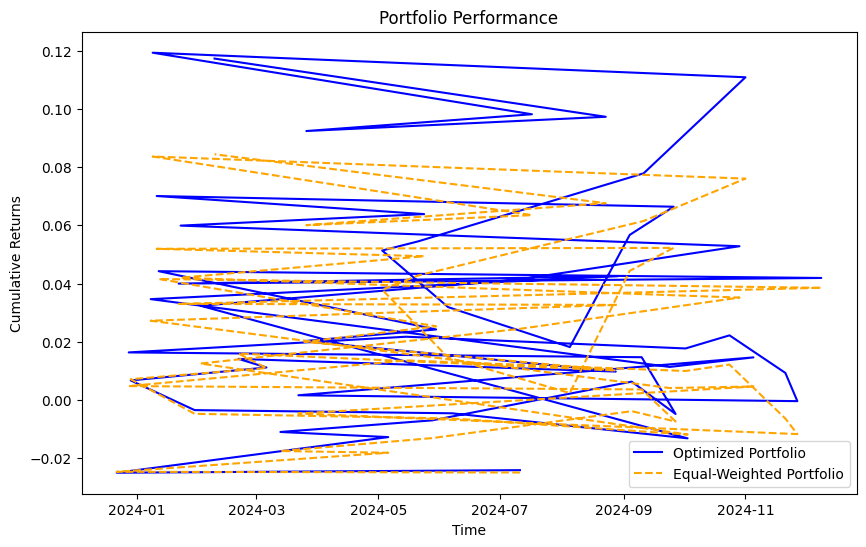

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Assuming X_test is a 2D array of stock returns (n_time_periods, n_stocks)
# Calculate the expected returns and covariance matrix
expected_returns = X_test.mean(axis=0)  # average returns for each stock
cov_matrix = X_test.cov()  # covariance matrix of the returns

# Number of assets (stocks)
n_assets = X_test.shape[1]

# Function to compute portfolio performance (e.g., negative Sharpe ratio or variance)
def objective(weights):
    # Portfolio return is weighted sum of expected returns
    portfolio_return = np.dot(weights, expected_returns)
    # Portfolio risk (variance) is weighted sum of covariances
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    # Negative Sharpe ratio (for minimization)
    return -portfolio_return / portfolio_volatility

# Constraints: weights must sum to 1 (fully invested portfolio)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds: weights must be between 0 and 1 for each asset (no short selling)
bounds = tuple((0, 1) for asset in range(n_assets))

# Initial guess: equal weights for all assets
initial_guess = np.ones(n_assets) / n_assets

# Optimize the portfolio weights
result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints)

# Get the optimal weights
if result.success:
    optimal_weights = result.x
    print("Optimal Weights:", optimal_weights)
else:
    raise ValueError("Optimization failed. Ensure that the input data is valid.")

# Calculate equal weights (assuming equal allocation to each stock)
equal_weights = np.ones(X_test.shape[1]) / X_test.shape[1]

# Calculate portfolio cumulative returns (optimized)
portfolio_returns = (X_test @ optimal_weights).cumsum()

# Calculate equal-weighted portfolio returns
equal_weighted_returns = (X_test @ equal_weights).cumsum()

# Create portfolio allocation dictionary
portfolio_allocation = {f"Stock {i+1}": optimal_weights[i] for i in range(len(optimal_weights))}

# Save allocations to a CSV file
allocations_df = pd.DataFrame.from_dict(portfolio_allocation, orient='index', columns=['Weight'])
allocations_df.to_csv('portfolio_allocations.csv')
print("Allocations saved to portfolio_allocations.csv")

# Save cumulative returns
portfolio_performance = pd.DataFrame({
    'Optimized Portfolio': portfolio_returns,
    'Equal-Weighted Portfolio': equal_weighted_returns
})
portfolio_performance.to_csv('portfolio_performance.csv')
print("Portfolio performance saved to portfolio_performance.csv")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns, label="Optimized Portfolio", color='blue')
plt.plot(equal_weighted_returns, label="Equal-Weighted Portfolio", color='orange', linestyle="--")
plt.title("Portfolio Performance")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()



Enhancemet in the project

Plotting with plotly

In [20]:
!pip install plotly
import plotly.graph_objs as go


In [21]:
# Create interactive portfolio performance plot with Plotly
portfolio_trace = go.Scatter(x=portfolio_returns.index, y=portfolio_returns, mode='lines', name='Optimized Portfolio', line=dict(color='blue'))
equal_weighted_trace = go.Scatter(x=equal_weighted_returns.index, y=equal_weighted_returns, mode='lines', name='Equal-Weighted Portfolio', line=dict(color='orange', dash='dash'))

# Layout
layout = go.Layout(
    title="Portfolio Performance",
    xaxis=dict(title='Time'),
    yaxis=dict(title='Cumulative Returns'),
    template='plotly_dark'
)

# Combine traces into a figure
fig = go.Figure(data=[portfolio_trace, equal_weighted_trace], layout=layout)

# Show the interactive plot
fig.show()


LSTM FOR TIMEE SERIES FORECASTING

CASE 1: ONE STOCK PRICE

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3157
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2675 
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2360 
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1444 
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1098 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


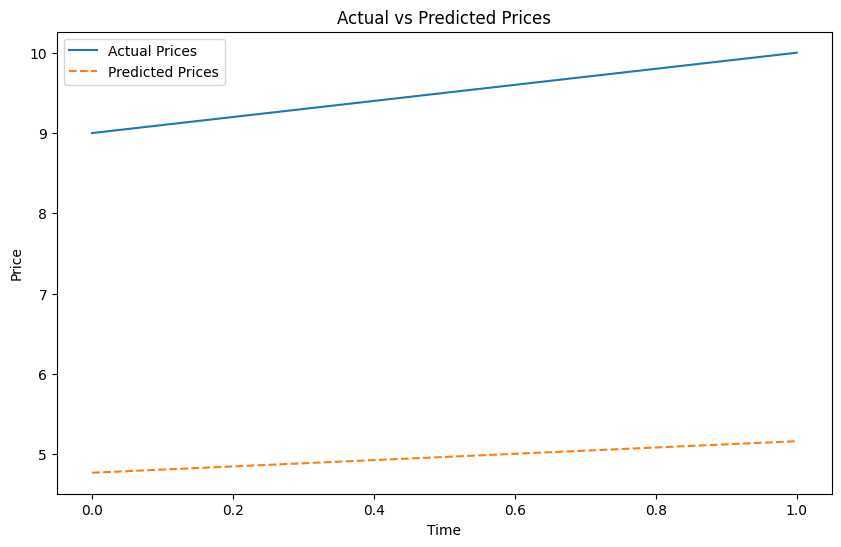

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Example: data is a 1D numpy array or pandas DataFrame of stock prices (single feature)
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  # Example stock prices

# Scale the data to the range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.reshape(-1, 1))  # Reshape to 2D for scaling

# Create sequences for LSTM input
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])  # Create sequences with window_size days
        y.append(data[i + window_size])    # The next value to predict
    return np.array(X), np.array(y)

window_size = 3  # Use the previous 3 days to predict the next day
X, y = create_sequences(scaled_data, window_size)

# Reshape X to be 3D [samples, time_steps, features] for LSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)  # Only 1 feature (stock price)

# Split into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))  # LSTM layer
model.add(Dense(units=1))  # Output layer (single value prediction)

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=1)

# Predict on the test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))  # Reverse the scaling of predictions

# Plot the actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Prices')  # Actual test data
plt.plot(predictions, label='Predicted Prices', linestyle='--')  # Predicted prices
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


CASE 2 MULTIPLE STOCK

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3735
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2559 
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2491 
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2556 
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1546 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


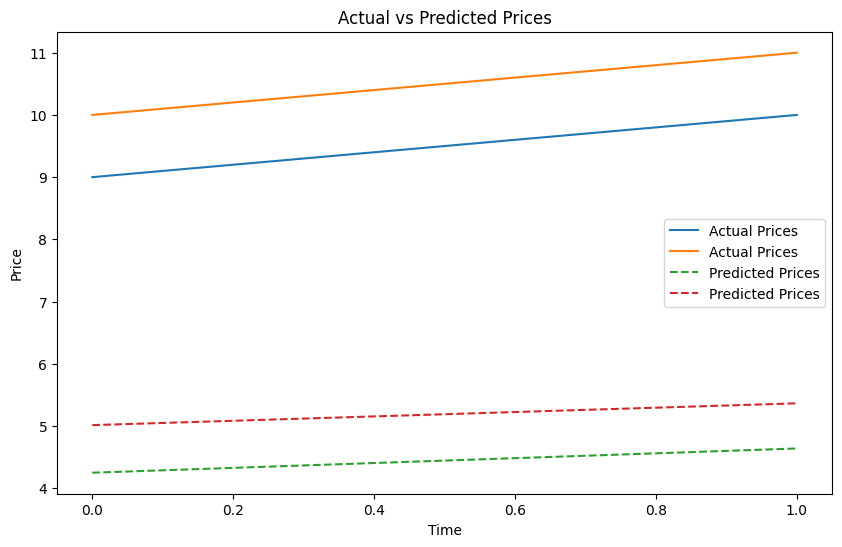

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Example: data is a 2D numpy array or pandas DataFrame of stock prices (multiple features)
data = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]])  # Example with 2 stocks

# Scale the data to the range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)  # No reshape needed if it's 2D already

# Create sequences for LSTM input
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])  # Create sequences with window_size days
        y.append(data[i + window_size])    # The next value to predict
    return np.array(X), np.array(y)

window_size = 3  # Use the previous 3 days to predict the next day
X, y = create_sequences(scaled_data, window_size)

# Reshape X to be 3D [samples, time_steps, features] for LSTM input
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])  # Multiple features

# Split into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))  # LSTM layer
model.add(Dense(units=2))  # Output layer (predicting 2 stock prices)

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=1)

# Predict on the test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Reverse the scaling of predictions

# Plot the actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(y_test), label='Actual Prices')  # Actual test data
plt.plot(predictions, label='Predicted Prices', linestyle='--')  # Predicted prices
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


Transaction Costs in Portfolio Optimization

In [38]:
import cvxpy as cp
import numpy as np

# Define stocks and mock data for returns and covariance matrix
stocks = ['AAPL', 'MSFT', 'GOOG', 'AMZN']

# Example expected returns (replace with real data)
expected_returns = np.array([0.08, 0.1, 0.09, 0.07])  # Annual returns

# Example covariance matrix (replace with real data)
cov_matrix = np.array([[0.0001, 0.00003, 0.00002, 0.00001],
                       [0.00003, 0.00015, 0.00004, 0.00003],
                       [0.00002, 0.00004, 0.0001, 0.00002],
                       [0.00001, 0.00003, 0.00002, 0.00012]])

# Define transaction costs per trade (e.g., 0.1% of the transaction value)
transaction_costs = 0.001

# New risk function considering transaction costs (linear cost model)
def portfolio_risk_with_costs(weights, prev_weights):
    cost = transaction_costs * cp.sum(cp.abs(weights - prev_weights))  # Transaction cost is proportional to change in weights
    risk = cp.quad_form(weights, cov_matrix)  # Quadratic form for risk
    return risk + cost

# Initialize previous weights (use numpy array for previous weights, constant zeros)
prev_weights = np.zeros(len(stocks))  # Use numpy array for previous weights (constant zeros)

# CVXPY variable for current weights
weights = cp.Variable(len(stocks))

# Risk function with transaction costs
risk = portfolio_risk_with_costs(weights, prev_weights)

# Expected return of the portfolio
expected_portfolio_return = expected_returns @ weights

# Define the problem to maximize the Sharpe ratio (return / risk), simplified without square root
problem = cp.Problem(
    cp.Maximize(expected_portfolio_return - risk),  # Objective: maximize return minus risk + transaction costs
    [cp.sum(weights) == 1, weights >= 0]  # Weights must sum to 1 and be non-negative
)

# Solve the optimization problem
problem.solve()

# Optimal weights considering transaction costs
optimal_weights_with_costs = weights.value
portfolio_allocation_with_costs = {stocks[i]: optimal_weights_with_costs[i] for i in range(len(stocks))}

print("Optimal Portfolio Allocation with Transaction Costs:", portfolio_allocation_with_costs)


Optimal Portfolio Allocation with Transaction Costs: {'AAPL': -2.3042569241424313e-05, 'MSFT': 1.0000691968704063, 'GOOG': -2.3049160974446798e-05, 'AMZN': -2.3035973280965688e-05}


SENTIMENT ANALYSIS FOR STOCK PREDICTION

In [39]:
!pip install textblob yfinance nltk
from textblob import TextBlob
import yfinance as yf
import pandas as pd
import numpy as np
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [40]:
!pip install requests
import requests
import pandas as pd


FETCH NEWS ARTICLES USING NEWSAPI

In [46]:
# Replace with your own NewsAPI key
api_key = 'ac74ced4570a4ef48cb2e2abbad1c82c'

# Define the endpoint URL
url = 'https://newsapi.org/v2/everything'

# Define the parameters (for Apple news in this example)
params = {
    'q': 'Apple',  # Keyword to search news articles for
    'from': '2024-12-01',  # Start date (optional)
    'to': '2024-12-12',  # End date (optional)
    'sortBy': 'publishedAt',  # Sort articles by publication date
    'apiKey': 'ac74ced4570a4ef48cb2e2abbad1c82c',  # Your NewsAPI key
    'language': 'en'  # English language news
}

# Fetch news data from NewsAPI
response = requests.get(url, params=params)
data = response.json()

# Check if the request was successful
if response.status_code == 200:
    print(f"Fetched {len(data['articles'])} articles.")
else:
    print(f"Failed to fetch articles: {data['message']}")


Fetched 100 articles.


In [47]:
# Extract relevant information from the response
articles = data['articles']
news_data = []

for article in articles:
    news_data.append({
        'title': article['title'],
        'description': article['description'],
        'url': article['url'],
        'publishedAt': article['publishedAt'],
        'source': article['source']['name']
    })

# Create a DataFrame from the articles data
news_df = pd.DataFrame(news_data)

# Display the first few rows of the news DataFrame
news_df.head()


,title,description,url,publishedAt,source
0,Scott Boras Takes Shot At New York Yankees At ...,"In case you missed it, prodigious slugger Juan...",https://brobible.com/sports/article/scott-bora...,2024-12-12T23:54:22Z,BroBible
1,Broadcom Shares Jump After Chipmaker Predicts ...,In This Article:\n(Bloomberg) -- Broadcom Inc....,https://biztoc.com/x/f6c484346599243a,2024-12-12T23:53:04Z,Biztoc.com
2,Appleが2025年に自社製ネットワークチップ搭載のApple TVとHomePod mi...,Appleが新たな技術革新の一歩を踏み出そうとしています。BloombergのMark Gu...,https://minatokobe.com/wp/apple/post-101344.html,2024-12-12T23:52:09Z,Minatokobe.com
3,Australia’s media movers and shakers on who su...,"From Jordan Baker to Justin Stevens, we asked ...",https://www.crikey.com.au/2024/12/13/crikey-me...,2024-12-12T23:50:59Z,Crikey
4,350-Powered ’30 Ford Model A Coupe Street Rod,This '30 Ford Model A is a steel-bodied coupe ...,https://bringatrailer.com/listing/1930-ford-mo...,2024-12-12T23:50:10Z,Bringatrailer.com


In [48]:
from textblob import TextBlob

# Perform sentiment analysis on article descriptions
news_df['sentiment'] = news_df['description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Display articles with their sentiment score
print(news_df[['title', 'sentiment']].head())


                                               title  sentiment
0  Scott Boras Takes Shot At New York Yankees At ...   0.068182
1  Broadcom Shares Jump After Chipmaker Predicts ...  -0.212500
2  Appleが2025年に自社製ネットワークチップ搭載のApple TVとHomePod mi...   0.368182
3  Australia’s media movers and shakers on who su...   0.037037
4      350-Powered ’30 Ford Model A Coupe Street Rod   0.000000


In [55]:
import yfinance as yf
import pandas as pd

# Download stock data for AAPL
stock_data = yf.download('AAPL', start='2023-12-13', end='2024-12-13')

# Example of integrating sentiment into the stock returns model
# Assuming you have a DataFrame `news_df` containing news sentiment scores and publication dates
# Convert the 'publishedAt' column in news_df to datetime format
news_df['publishedAt'] = pd.to_datetime(news_df['publishedAt'], errors='coerce')

# Group sentiment scores by publication date and calculate mean sentiment for each day
sentiment_scores = news_df.groupby('publishedAt')['sentiment'].mean().fillna(0)

# Align the sentiment scores with the stock data dates
# Remove timezone from stock_data index to make it timezone-naive
stock_data.index = stock_data.index.tz_localize(None)

# Ensure stock_data.index and sentiment_scores index are both timezone-naive (if needed)
sentiment_scores.index = pd.to_datetime(sentiment_scores.index).tz_localize(None)

# Reindex sentiment scores to align with stock data dates (forward fill sentiment)
stock_data['sentiment'] = sentiment_scores.reindex(stock_data.index, method='ffill')  # Forward fill sentiment

# Now you can use this combined data for stock prediction models
print(stock_data.head())


[*********************100%***********************]  1 of 1 completed

Price        Adj Close       Close        High         Low        Open  \
Ticker            AAPL        AAPL        AAPL        AAPL        AAPL   
Date                                                                     
2023-12-13  196.994919  197.960007  198.000000  194.850006  195.089996   
2023-12-14  197.144180  198.110001  199.619995  196.160004  198.020004   
2023-12-15  196.606827  197.570007  198.399994  197.000000  197.529999   
2023-12-18  194.935013  195.889999  196.630005  194.389999  196.089996   
2023-12-19  195.979889  196.940002  196.949997  195.889999  196.160004   

Price          Volume sentiment  
Ticker           AAPL            
Date                             
2023-12-13   70404200       NaN  
2023-12-14   66831600       NaN  
2023-12-15  128256700       NaN  
2023-12-18   55751900       NaN  
2023-12-19   40714100       NaN  


In [56]:
print(stock_data[['Adj Close', 'sentiment']].head())


Price        Adj Close sentiment
Ticker            AAPL          
Date                            
2023-12-13  196.994919       NaN
2023-12-14  197.144180       NaN
2023-12-15  196.606827       NaN
2023-12-18  194.935013       NaN
2023-12-19  195.979889       NaN


Reinforcement Learning for Dynamic Portfolio Management

Data Collection

In [57]:
import yfinance as yf

# Fetch historical data for a set of stocks
stocks = ['AAPL', 'MSFT', 'GOOG', 'AMZN']
data = yf.download(stocks, start='2023-12-13', end='2024-12-13')['Adj Close']

# Calculate daily returns for each stock
returns = data.pct_change().dropna()

# Display the data
returns.head()


[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOG,MSFT
Date,,,,
2023-12-14,0.000758,-0.009540,-0.005748,-0.022545
2023-12-15,-0.002726,0.017298,0.004805,0.013117
2023-12-18,-0.008503,0.027339,0.025030,0.005179
2023-12-19,0.005360,-0.001817,0.006633,0.001637
2023-12-20,-0.010714,-0.010859,0.011296,-0.007073


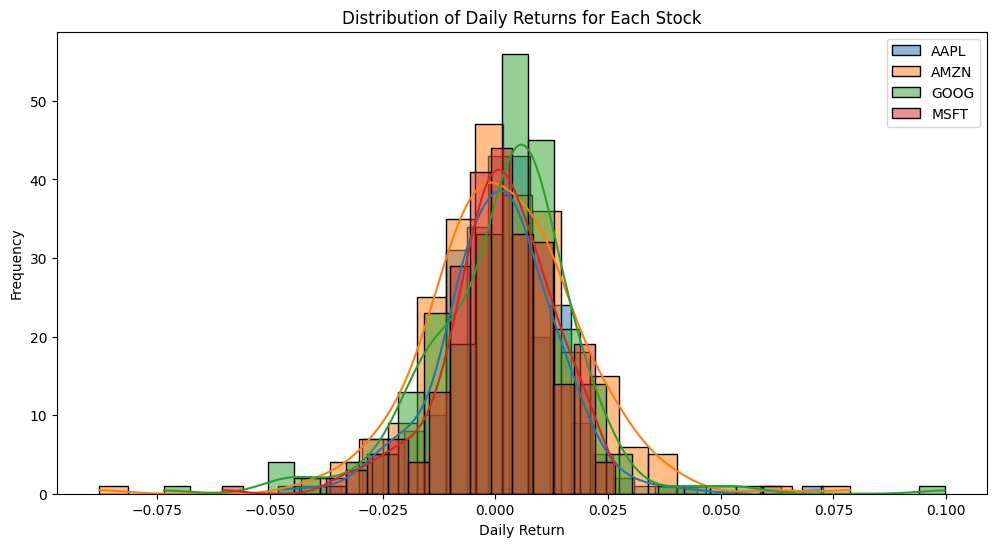

In [58]:
# @title Distribution of Daily Returns for Each Stock

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Using Seaborn for better visualization
sns.histplot(returns['AAPL'], label='AAPL', kde=True)
sns.histplot(returns['AMZN'], label='AMZN', kde=True)
sns.histplot(returns['GOOG'], label='GOOG', kde=True)
sns.histplot(returns['MSFT'], label='MSFT', kde=True)

plt.title('Distribution of Daily Returns for Each Stock')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
_ = plt.legend()


Environment Defining

In [59]:
!pip install gym


**TRAINING THE RL AGENT**

In [63]:
import numpy as np
import random
import yfinance as yf

# Simulated stock trading environment (replace with a more realistic one)
class StockTradingEnv:
    def __init__(self, data):
        self.data = data
        self.current_step = 0
        self.action_space = 3  # Buy, Hold, Sell
        self.done = False

    def reset(self):
        self.current_step = 0
        self.done = False
        # Return the initial state (e.g., the first stock price)
        return self.current_step

    def step(self, action):
        # Simulate the next step of the environment (here, simplistic)
        current_price = self.data[self.current_step]
        if action == 0:  # Buy
            reward = self.data[self.current_step + 1] - current_price  # Assume reward is price change
        elif action == 1:  # Hold
            reward = 0
        else:  # Sell
            reward = current_price - self.data[self.current_step + 1]

        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            self.done = True

        # Return the next state (index) and the reward
        next_state = self.current_step
        return next_state, reward, self.done, {}

# Example stock data (use 'Close' column for simplicity)
stock_data = yf.download('AAPL', start='2023-12-13', end='2024-12-13')
data = stock_data['Close'].values  # Extracting closing prices

print(stock_data.head())  # Print first few rows of stock data

# Q-learning hyperparameters
alpha = 0.1    # Learning rate
gamma = 0.99   # Discount factor
epsilon = 0.1  # Exploration rate
n_episodes = 1000

# Initialize the Q-table (state-action values)
n_actions = 3  # For simplicity, assume 3 discrete actions: buy, hold, sell
env = StockTradingEnv(data)  # Initialize the environment
Q = np.zeros((len(data), n_actions))  # Q-table size should match the number of stock prices

# Q-learning algorithm
for episode in range(n_episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        # Choose action based on epsilon-greedy policy
        if random.uniform(0, 1) < epsilon:
            action = random.choice(range(n_actions))  # Explore
        else:
            action = np.argmax(Q[state])  # Exploit

        # Perform the action
        next_state, reward, done, _ = env.step(action)

        # Update Q-table using the Q-learning update rule
        Q[state][action] = Q[state][action] + alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])

        state = next_state
        total_reward += reward

    print(f"Episode {episode + 1}/{n_episodes}, Total Reward: {total_reward}")


[*********************100%***********************]  1 of 1 completed
<ipython-input-63-8fc4863ef3ae>:71: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Price        Adj Close       Close        High         Low        Open  \
Ticker            AAPL        AAPL        AAPL        AAPL        AAPL   
Date                                                                     
2023-12-13  196.994919  197.960007  198.000000  194.850006  195.089996   
2023-12-14  197.144180  198.110001  199.619995  196.160004  198.020004   
2023-12-15  196.606827  197.570007  198.399994  197.000000  197.529999   
2023-12-18  194.935013  195.889999  196.630005  194.389999  196.089996   
2023-12-19  195.979889  196.940002  196.949997  195.889999  196.160004   

Price          Volume  
Ticker           AAPL  
Date                   
2023-12-13   70404200  
2023-12-14   66831600  
2023-12-15  128256700  
2023-12-18   55751900  
2023-12-19   40714100  
Episode 1/1000, Total Reward: [47.25001526]
Episode 2/1000, Total Reward: [276.52993774]
Episode 3/1000, Total Reward: [261.62991333]
Episode 4/1000, Total Reward: [274.26992798]
Episode 5/1000, Total Reward: [295.5

**EVALUATION**

In [64]:
# Test the learned agent
state = env.reset()
done = False
total_reward = 0

while not done:
    action = np.argmax(Q[state])
    next_state, reward, done, _ = env.step(action)
    state = next_state
    total_reward += reward

print(f"Total Reward (Portfolio Return): {total_reward}")


Total Reward (Portfolio Return): [402.74987793]
